# The weighted generalized mean model of concurrency with Raphson's method

In [1]:
%matplotlib inline

/home/dini/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from collections import defaultdict
from pprint import pprint
import theano
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from theano import pp
from theano import tensor as T
from theano import function
from theano.ifelse import ifelse
import numpy as np

# An exhaustive study of the errors based on synthetic data
In this notebook I am trying to assess the error in estimating the response time of a transaction introduced by using the weighted generalized mean of the response times of the child transactions as the model of concurrency.

The method of the assessment is to compare the prediction errors when the model is trained on data that is generated by the weighted generalized mean model versus on data generated by the concurrency structure model introduced in notebook [Modelling the concurrency pattern of RPC calls with a directed acyclic graph](DAG-01.ipynb).
### The weighted generalized mean model

$$
M(\mathbf{x}, \mathbf{w}, p) =  
 \left\{
  \begin{array}{cl}
	\left(\sum_{i=1}^n w_i x_i^p \right)^{\frac{1}{p}}
 	& \texttt{if } p \neq 0 \\
 	\prod_{i=1}^n x_i^{w_i}
 	& \texttt{if } p=0 \\
  \end{array}
 \right.
$$
.
$$
RT(\mathbf{x}, \mathbf{w}, p, \mu,\sigma) = M(\mathbf{x}, \mathbf{w}, p)  + \exp({\mathcal{N}(\mu,\,\sigma^{2})\,})
$$
.
$$
\mathbf{x} = \exp({\mathcal{N}(...,\,...)\,})
$$


## Synthetize data 
I provide two different ways to synthetize data: one that matches exactly the model and another one that is closer to how a real-life distributed system behaves.

As the goal is to compare the systematic error, the additive noise is set to 0 in both cases. Another reason for this setting is that (due to the two models generating the noise slightly differently) this is the only noise level at which I can easily ensure that the noise in the generated data is identical.
### Generate data with the weighted generalized mean
This method uses the model defined above to generate the data, i.e. it computes the parent response time as the weighted generalized mean of the response time of the child transactions plus a log-normal noise. The child response times are also sampled from a log-normal distribution.

This model assumes the same concurrency pattern (be that sequential or parallel) for all of the children, approximating concurrency patterns where some of the child transactions are executed concurrently while others sequentially with a pattern that is somewhere between purely sequential and purely parallel. 

In [3]:
class WeightedPNormSampler(object):
    
    def __init__(self, locX, scaleX, w, p, mu, sigma, training_set_size, validation_set_size, test_set_size):
        """ @param locX: location parameters of log-norm distribution of child transactions
            @param scaleX: scale parameters of log-norm distribution of child transactions
            @param w: weigth parameters of child transactions
            @param p: 
            @param mu: locataion param of log-norm additive noise
            @param sigma: scale param of log-norm additive noise
        """
        self.locX, self.scaleX, self.real_w, self.real_p, self.real_mu, self.real_sigma, = \
             locX,      scaleX,           w,           p,           mu,          sigma, 
        self.training_set_size, self.validation_set_size, self.test_set_size = \
             training_set_size,      validation_set_size,      test_set_size
            
        self.num_children = len(locX)    
        assert self.locX.shape == (self.num_children,)
        assert self.scaleX.shape == (self.num_children,)
        assert self.real_w.shape == (self.num_children,)
        if verbose:
            print "Generating {} training, {} validation and {} test samples using the following parameters:" \
                .format(training_set_size, validation_set_size, test_set_size)
            print "locX = {}        scaleX = {}".format(self.locX, self.scaleX)
            print "w = {},        p = {},        mu = {},        sigma = {}"\
                    .format(self.real_w, self.real_p, self.real_mu, self.real_sigma)
        self.train_X_samples     , self.train_RT_samples      = self._sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self._sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self._sample(test_set_size      ,)

    def _sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = np.stack((np.exp(np.random.normal(self.locX[child], 
                                                           self.scaleX[child], N)) 
                                   for child in range(self.num_children)), axis=1)
        M = np.power(np.dot(np.power(X_samples, self.real_p), self.real_w), 1.0/self.real_p)
        RT_samples = M + np.exp(np.random.normal(self.real_mu, self.real_sigma, len(M)))
        return X_samples, RT_samples
  
    @classmethod
    def random_data(cls, num_children, training_set_size, validation_set_size, test_set_size):
        locX = np.random.uniform(-1, 1, num_children)
        scaleX = np.random.uniform(0, 2, num_children)
        real_w = np.random.uniform(0, 1, num_children)
        real_p = np.random.uniform(0.4, 4)
        real_mu = np.random.uniform(-1, 1)
        real_sigma = 0.0 # 1.0
        data = cls(locX, scaleX, real_w, real_p, real_mu, real_sigma, 
                                   training_set_size=training_set_size, 
                                   validation_set_size=validation_set_size, 
                                   test_set_size=test_set_size)
        return data
        


### Generate data from a concurrency structure
The second method samples from a pre-determined *concurrency structure* (see the notebook [Modelling the concurrency pattern of RPC calls with a directed acyclic graph](DAG-01.ipynb)).

A concurrency structure is a composition of parametrized transaction blueprints through the `-` (serial execution) and `|` (parallel execution) operators. 

This model closely simulates concurrency patterns where some of the child transactions are executed concurrently while others sequentially.

In [4]:
class _NonSeq(object):
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.append(self)
            return other
        else:
            return Sequential((self, other))

class _NonPar(object):
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.append(self)
            return other
        else:
            return Parallel((self, other))

class Sequential(list, _NonPar):
    
    def __str__(self):
        return "(" + " - ".join(str(x) for x in self) + ")"
    __repr__ = __str__
        
    def __sub__(self, other):
        if isinstance(other, Sequential):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def collect_events(self, events, X, refTime=0):
        for child in self:
            refTime = child.collect_events(events, X, refTime) 
        return refTime

class Parallel(list, _NonSeq):

    def __str__(self):
        return "(" + " | ".join(str(x) for x in self) + ")"
    __repr__ = __str__
    
    def __or__(self, other):
        if isinstance(other, Parallel):
            other.extend(self)
            return other
        else:
            self.append(other)
            return self

    def collect_events(self, events, X, refTime=0):
        return max(child.collect_events(events, X, refTime) for child in self)
            
class Trx(_NonSeq, _NonPar):
    
    def __init__(self, name, loc=0., scale=1., alpha=-1.0, beta=.10):
        self.name, self.loc, self.scale, self.alpha, self.beta = \
             name,      loc,      scale,      alpha,      beta
        
    def __str__(self):
        if self.loc != 0 or self.scale != 1.:
            return "Trx('{}', {:3.1f}, {:3.1f})".format(self.name, self.loc, self.scale)
        else:
            return "Trx('{}')".format(self.name)
    __repr__ = __str__
        
    def collect_events(self, events, X, refTime=0):
        start  = refTime + np.exp(np.random.normal(self.loc + self.alpha, self.scale * self.beta))
        finish = start   + np.exp(np.random.normal(self.loc             , self.scale            ))
        events.extend([(start, "{" + self.name), (finish, self.name + "}")])
        X.append(finish - start)
        return finish

class StructureSampler(object):
    
    def __init__(self, structure, num_children, training_set_size, validation_set_size, test_set_size):
        self.structure = structure
        self.num_children = num_children
        if verbose:
            print ("Generating {} training, {} validation and {} test samples "
                   "using the following concurrency structure:" \
                    .format(training_set_size, validation_set_size, test_set_size))
            print structure
        self.train_X_samples     , self.train_RT_samples      = self._sample(training_set_size  ,) 
        self.validation_X_samples, self.validation_RT_samples = self._sample(validation_set_size,)  
        self.test_X_samples      , self.test_RT_samples       = self._sample(test_set_size      ,)

    def _sample(self, N, ):
        """ @param N: number of samples to generate
        """
        X_samples = list()
        RT_samples = list()
        for i in range(N):
            events = list()
            X = list()
            RT = self.structure.collect_events(events, X)
            X_samples.append(X)
            RT_samples.append(RT)
            
        X_samples = np.array(X_samples)
        RT_samples = np.array(RT_samples)
        return X_samples, RT_samples
        
    @classmethod
    def random_data(cls, num_children, training_set_size, validation_set_size, test_set_size, ):
        loc = np.random.uniform(-1, 1)
        spread = np.random.uniform(0, 2)
        beta = 0
        structure = Trx(str(0), loc, spread, beta=beta)
        #np.random.seed(i)
        loc = np.random.uniform(-1, 1, num_children)
        spread = np.random.uniform(0, 2, num_children)
        for i in range(1, num_children):
            ii = str(i)
            if np.random.uniform() > 0.5:
                structure |= Trx(ii, loc[i], spread[i], beta=beta)
            else:
                structure -= Trx(ii, loc[i], spread[i], beta=beta)

        data = cls(structure, num_children, training_set_size=training_set_size, 
                                            validation_set_size=validation_set_size, 
                                            test_set_size=test_set_size)
        return data


In [5]:
verbose = True
data = StructureSampler.random_data(num_children=3, training_set_size=5, validation_set_size=0, test_set_size=0, )
data.train_X_samples, data.train_RT_samples

Generating 5 training, 0 validation and 0 test samples using the following concurrency structure:
(Trx('0', 0.3, 0.4) | Trx('1', 0.7, 0.0) | Trx('2', -0.3, 0.1))


(array([[ 0.91163075,  2.09199939,  0.78465439],
        [ 2.9063508 ,  2.10589857,  0.78506325],
        [ 2.06758093,  2.09985594,  0.6600303 ],
        [ 2.15363814,  2.13242009,  0.78176546],
        [ 1.48929034,  2.04383537,  0.76139082]]),
 array([ 2.85946276,  3.42331445,  2.86731931,  2.89988345,  2.81129874]))

## Raphson's method to fit the weighted generalized mean model
The fitting happens in the `__init__()` method. The Hessian is regularized with a unit matrix weighted by $\lambda$ (in the code `l_`). The iteration starts with a very strong regulazation, which is relaxed in exponential steps as the iteration progresses.

In [6]:
%%time
class WeightedPNormNR(object):
    """ Newton-raphson method to fit a weighted p-norm model. 
    
        See https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization
    """
    l = T.dscalar('lambda')  # regularization parameter
    # the model parameters
    wpm = theano.shared(np.zeros(5), 'wpm')    #T.concatenate([w, T.stack([p, m])])

    # model parameter: weights of child transactions
    w = wpm[:-2]
    # model parameter: power of child resp times
    p = wpm[-2]
    # # model param: 
    # mu = theano.shared(0.0, 'mu')        # mean of normal distrib
    # sigma = theano.shared(1.0, 'sigma')  # stddev of normal
    # for now we use 
    m = wpm[-1]

    # every row (selected by 0th coord) is an observation, 
    # fields in a row (1st coord) are child trx resp time in the observation
    X = T.dmatrix('X')  

    # parent resp time, each observation on a separate row
    y = T.dvector('y')

    step_size = T.dscalar('step_size')

    # The expected response time from the model we use:
    XP = T.pow(X, p)
    XPw = T.dot(XP, w)
    #sXPw = T.sum(XPw, axis=0)
    RT = T.pow(XPw, 1/p) + T.exp(m)

    # residual:
    epsilon = y - RT
    
    # penalty if sum of w is not one ...
    #regularization_1 = T.pow((w - 1.0/num_children), 2).sum()*1e-1
    # ... and if negative
    regularization_2 = T.exp((-w-.05)*100).sum() + T.exp((w-1.1)*100).sum() + T.exp(-p*100) + T.exp((p-10)*100)
    
    # Mean squared error
    MSE = 0.5 * T.pow(epsilon, 2).mean() 
    
    # the cost function
    E = MSE + regularization_2

    # the gradient:
    gradE = T.grad(E, wpm)
    
    # the hessian:
    H = T.hessian(E, wpm)    
    regularizatoin = T.diag(T.ones((wpm.shape[0],)) * l)
    Hinv = T.nlinalg.matrix_inverse(H + regularizatoin)
    
    # The inverse is computed by V.D^{-1}.U
    Hinv_gradE = T.dot(Hinv, gradE)    
    new_wpm = wpm - step_size * Hinv_gradE
    
    training_result_variables = ('wpm', 'XPw', 'RT', 'epsilon', 'regularization_2', 'MSE', 'E',  
                                 'gradE', 'Hinv', 'new_wpm', )
    train = staticmethod(theano.function(
              inputs=[X, y, step_size, l],
              outputs=[wpm, XPw, RT, epsilon, regularization_2, MSE, E, gradE, Hinv, new_wpm],
              updates=((wpm, new_wpm), )
    ))
    prediction_result_variables = 'RT', 'epsilon', 'MSE'
    predict = staticmethod(theano.function(inputs=[X, y], outputs=[RT, epsilon, MSE]))

    def __init__(self, w_init, p_init, m_init, step_size_, l_min, l_max, training_steps, data, MSE_limit):
        self.w_init, self.p_init, self.m_init, self.step_size_, self.training_steps,  self.MSE_limit = \
             w_init,      p_init,      m_init,      step_size_,      training_steps,       MSE_limit
        self.l_max, self.l_min, = l_max, l_min
            
        if verbose:
            print ("Training the model using the following parameters:"
                   "\nstep_size = {},\tlambda_min = {},\tlambda_max = {},\ttraining_steps = {}" \
                    .format(step_size_, l_min, l_max, training_steps))
            
        self.wpm.set_value(np.concatenate((self.w_init, np.stack((self.p_init, self.m_init)))))

        lambdas = sorted(np.logspace(l_min, l_max, self.training_steps), reverse=True)
        for i, l_ in zip(range(self.training_steps), lambdas):
            result = WeightedPNormNR.train(data.train_X_samples, data.train_RT_samples, self.step_size_, l_)
            wpm, XPw, RT, epsilon, regularization_2, MSE, E, gradE, Hinv, new_wpm = result
            if MSE < MSE_limit:
                break

        self.training_results = dict(zip(self.training_result_variables, result))
        self.training_results['i'] = i
        if verbose:
            print "MSE = {}".format(self.training_results['MSE'])

    def __call__(self, data):
        prediction_result = self.predict(data.test_X_samples, data.test_RT_samples)
        return dict(zip(self.prediction_result_variables, prediction_result))
        
        
    @classmethod
    def evaluate_init(cls, step_size, training_steps, data, N):
        """ Determine how the starting point of the iteration impacts the end-result.
        """
        results = defaultdict(list)
        for i in range(N):
            w_init = np.random.uniform(0, 1, data.num_children)
            p_init = np.random.uniform(0.4, 4)
            m_init = np.random.uniform(-5, 5)
            wpn = WeightedPNormGradDesc(w_init, p_init, m_init, step_size, training_steps, data)
            results['w'].append(w)
            results['p'].append(p)
            results['mu'].append(m)  # (m, data.real_mu + data.real_sigma^2 /2)

        pass  # plot RT_samples vs. RT_predictions
        pass  # plot the distribution of epsilon    
        return results
    
    @classmethod
    def evaluate_real(cls, Sampler, num_children, step_size, l_min, l_max, training_steps, N, MSE_limit):
        """ Determine how the real values of the model parameters impact the error.
        """
        w_init = np.ones(num_children) / num_children
        p_init = 1.0
        m_init = 0.0
        results = list() 
        for i in range(N):
            if verbose:
                print "i = {}".format(i)
            data = Sampler.random_data(num_children=num_children, training_set_size=5000, 
                                       validation_set_size=0, test_set_size=5000)
            wpn = WeightedPNormNR(w_init, p_init, m_init, step_size, l_min, l_max, training_steps, data, MSE_limit)
            results.append( (data, wpn.training_results, wpn(data)))
        return results    

CPU times: user 14.2 s, sys: 474 ms, total: 14.7 s
Wall time: 17.8 s


### Plotting functions

In [7]:
def plot_MSE_vs_MSE(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['MSE'].append((2.0*wpn_results['MSE'], 2.0*prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('MSE computed on the training vs. test data sets ')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.scatter(*zip(*data), alpha=0.5)
        plt.xlabel('Training MSE')
        plt.ylabel('Test MSE')
        plt.show()

In [8]:
def plot_MSE_vs_real(results):
    series = defaultdict(list)
    for data, wpn_results, prediction_results in results:
        series['w_0'].append((data.real_w[0], 2.0*prediction_results['MSE'], ))
        series['w_1'].append((data.real_w[1], 2.0*prediction_results['MSE'], ))
        series['w_2'].append((data.real_w[2], 2.0*prediction_results['MSE'], ))
        series['p'  ].append((data.real_p   , 2.0*prediction_results['MSE'], ))
        series['m'  ].append((data.real_mu + data.real_sigma**2.0/2, 2.0*prediction_results['MSE'], ))
    
    for parameter, data in series.items():
        plt.title('Dependence of the MSE on the actual value of {}'.format(parameter))
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel(parameter)
        plt.ylabel('Test MSE')
        plt.show()

In [9]:
def plot_actual_vs_prediction(results):
    series = defaultdict(list)
    for data, training_results, prediction_results in results:
        series['w_0'].append((training_results['wpm'][0], data.real_w[0], ))
        series['w_1'].append((training_results['wpm'][1], data.real_w[1], ))
        series['w_2'].append((training_results['wpm'][2], data.real_w[2], ))
        series['p'  ].append((training_results['wpm'][3], data.real_p, ))
        series['m'  ].append((training_results['wpm'][4], data.real_mu + data.real_sigma**2.0/2, ))
    
    for title, data in series.items():
        plt.title(title)
        plt.grid()
        plt.scatter(*zip(*data))
        plt.xlabel('prediction')
        plt.ylabel('actual')
        plt.show()

In [10]:
def log_normal_variance(mu, sigma):
    sigma2 = sigma * sigma
    return (np.exp(sigma2) - 1) * np.exp(2.0*mu + sigma2)

In [11]:
def plot_MSE_vs_variance(results):
    data = list()
    for wpn_sample, training_results, prediction_results in results:
        data.append((log_normal_variance(wpn_sample.real_mu,  wpn_sample.real_sigma), 2.0*training_results['MSE'],) )
    
    plt.title('Training MSE vs. theoretical lower bound (variance)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.scatter(*zip(*data), alpha=0.5)
    plt.xlabel('Theoretical lower bound (variance)')
    plt.ylabel('Training MSE')
    plt.show()

In [12]:
def plot_MSE_vs_variance(results):
    data = list()
    for wpn_sample, training_results, prediction_results in results:
        data.append((log_normal_variance(wpn_sample.real_mu,  wpn_sample.real_sigma), 2.0*training_results['MSE'],) )
    
    plt.title('Training MSE vs. theoretical lower bound (variance)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.scatter(*zip(*data), alpha=0.5)
    plt.xlabel('Theoretical lower bound (variance)')
    plt.ylabel('Training MSE')
    plt.show()

## Evaluate the fitting algorithm on weighted generalized mean data
We repeat the exercise of fitting the model to noisy weighted generalized mean data from [the previous version of this notebook](weighted p-norm 04 - NR.ipynb) for the sake of the comparison with data generated from the concurrency structure.

### Generate data points for the evaluation
For each data point:

- a random value for the parameters locX, scaleX, real_w, real_p, real_mu, real_sigma is chosen
- a training and a test data sets are generated
- the model is fit to the training data
- a prediction is generated on the test data using the fit model

In [13]:
%%time
verbose = True
pnorm_results = WeightedPNormNR.evaluate_real(WeightedPNormSampler, num_children=10,
                                        step_size=.05, l_min=-2, l_max=4, training_steps = 500, N=50, MSE_limit=0.01)

i = 0
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [-0.4845985   0.92175277  0.04732175 -0.02529072  0.1369797  -0.38847794
  0.53516109 -0.13982623 -0.66450418  0.11810551]        scaleX = [ 1.47975268  0.90282427  0.60546691  0.10075875  1.45496411  0.78942545
  1.28248732  1.08957978  0.70735303  1.65471421]
w = [ 0.16263753  0.46653567  0.37125059  0.04686935  0.68661088  0.39488291
  0.51004683  0.89324526  0.93571532  0.26053487],        p = 2.30292460961,        mu = -0.794694032894,        sigma = 0.0
Training the model using the following parameters:
step_size = 0.05,	lambda_min = -2,	lambda_max = 4,	training_steps = 500
MSE = 0.00984444158628
i = 1
Generating 5000 training, 0 validation and 5000 test samples using the following parameters:
locX = [ 0.81429873 -0.84133089 -0.12607086 -0.44825954  0.0891177  -0.99387241
  0.11164387  0.55054632 -0.38163001  0.47304719]        scaleX = [ 0.71327104  0.19359774  0.72935619  0

In [14]:
#theano.config.exception_verbosity='high'
#theano.config.optimizer='None' #'fast_compile'

### Examine the mean squared error on the training and test data sets

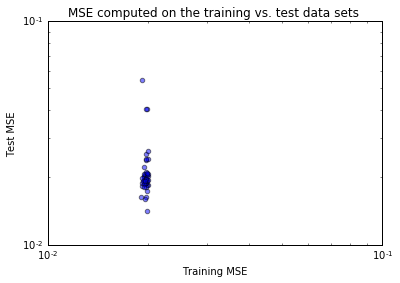

In [15]:
plot_MSE_vs_MSE(pnorm_results)

There seems to be no particular domain of any of the parameters that cause high MSE.

## Evaluate the fitting algorithm on data sampled from concurrency structures
### Generate the data

In [38]:
%%time
verbose = True
structure_results = WeightedPNormNR.evaluate_real(StructureSampler, num_children=10,
                                              step_size=.025, l_min=-2, l_max=4, 
                                              training_steps = 1000, N=50, MSE_limit=0.01)

i = 0
Generating 5000 training, 0 validation and 5000 test samples using the following concurrency structure:
((((((Trx('0', 0.6, 0.5) | Trx('1', 0.8, 1.3)) - Trx('2', -0.5, 1.5) - Trx('3', 0.3, 1.5) - Trx('4', 0.1, 0.9)) | Trx('5', 0.6, 0.9)) - Trx('6', -0.3, 1.0)) | Trx('7', -0.6, 0.9)) - Trx('8', -0.2, 0.2) - Trx('9', -0.0, 0.7))
Training the model using the following parameters:
step_size = 0.025,	lambda_min = -2,	lambda_max = 4,	training_steps = 1000
MSE = 0.686580510878
i = 1
Generating 5000 training, 0 validation and 5000 test samples using the following concurrency structure:
((((Trx('0', 0.8, 1.8) - Trx('1', 0.7, 1.3) - Trx('2', -0.2, 0.6) - Trx('3', 0.5, 2.0) - Trx('4', 0.7, 0.5) - Trx('5', -0.5, 0.6)) | Trx('6', -1.0, 1.6) | Trx('7', -0.3, 0.2)) - Trx('8', -0.5, 1.0)) | Trx('9', 1.0, 0.1))
Training the model using the following parameters:
step_size = 0.025,	lambda_min = -2,	lambda_max = 4,	training_steps = 1000
MSE = 1.17212412166
i = 2
Generating 5000 training, 0 validatio

### Compare the training MSE to the test MSE

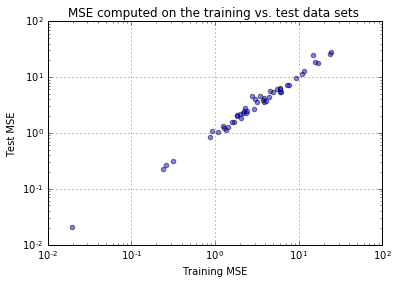

In [44]:
plot_MSE_vs_MSE(structure_results)

The training and test MSE are aligned.
### Assessing the performance of the model
#### Choosing a performance metric
My ultimate goal is to classify the transactions as healthy or anomalous based on their response times. The  frequency of the anomalies we want to detect is low, in the range of $1$ in $10^5$, therefore it is important to keep the false positive rate of the classification low. 

Based in this consideration the performance metric chosen is *accuracy gain*, i.e. the improvement in a high percentile of the prediction error. More precisely, the mean of the (parent transaction) response times is taken as a baseline estimator (i.e. the baseline estimator does not use any information about the response times of the child transactions), and a high percentile of it (say the 90th) is computed. Then the same percentile of the errors by the weighted p-norm model estimator is taken. The (baseline, p-norm model) tuples are displayed on a scatter plot.

I analyse the accuracy gain on two kinds of data sets. To the left a p-norm model is fit to data generated by a p-norm model, i.e. the same kind of model generates the data as it is fit to. To the right a p-norm model is fit to the data generated by a concurrency structure model.
#### Code

In [45]:
def plot_accuracy_gainuracy_gain(pnorm_results, structure_results, percentile):
    figure = plt.figure(figsize=(15, 5))
    figure.suptitle('Accuracy gain ({}th percentile of error in baseline vs. model)'.format(percentile),
                    fontsize=14
                   )
    x_min, x_max = y_min, y_max = 1e99, 0
    for i, (results, kind) in enumerate(((pnorm_results, "p-norm"), (structure_results, "concurrency structure"))):
        data = list()
        for wpn_sample, training_results, prediction_results in results:
            epsilon_before = wpn_sample.test_RT_samples - wpn_sample.test_RT_samples.mean()
            epsilon_after = prediction_results['epsilon']
            data.append((np.percentile(epsilon_before, percentile), np.percentile(epsilon_after, percentile)) )
            
        before, after = zip(*data)
        m = min(before)
        if x_min > m: x_min = m
        m = max(before)
        if x_max < m: x_max = m
        m = min(after)
        if y_min > m: y_min = m
        m = max(after)
        if y_max < m: y_max = m
            
        plt.subplot(1, 2, i+1)           
        plt.title('Fit to data generated by the {} model'.format(kind))
#         plt.xscale('log')
#         plt.yscale('log')
        plt.grid()
        plt.scatter(*zip(*data), alpha=0.5)
        plt.xlabel('Baseline')
        plt.ylabel('Model')
    round_up = lambda m: np.exp((np.around(np.log(m)/np.log(10)) + 1) * np.log(10))
#     x_max = round_up(x_max)
#     y_max = round_up(y_max)
    y_min = 0
    for i in range(1, 3):
        plt.subplot(1, 2, i)           
        plt.xlim((x_min-1, 1.05*x_max+1))
        plt.ylim((y_min-1, 1.05*y_max+1))
    plt.show()    

#### Results

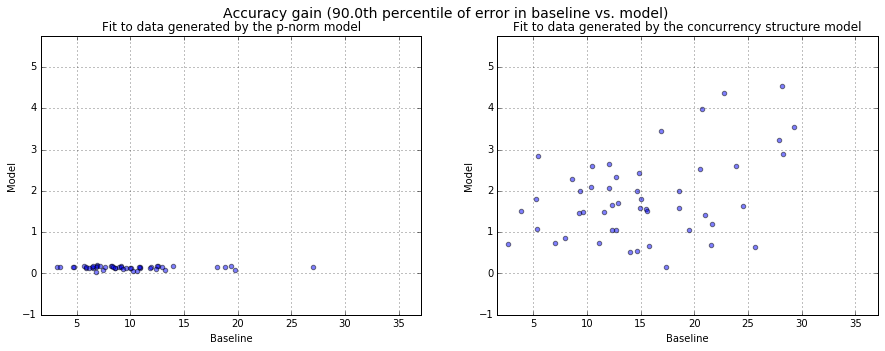

In [46]:
plot_accuracy_gainuracy_gain(pnorm_results, structure_results, percentile=90.)

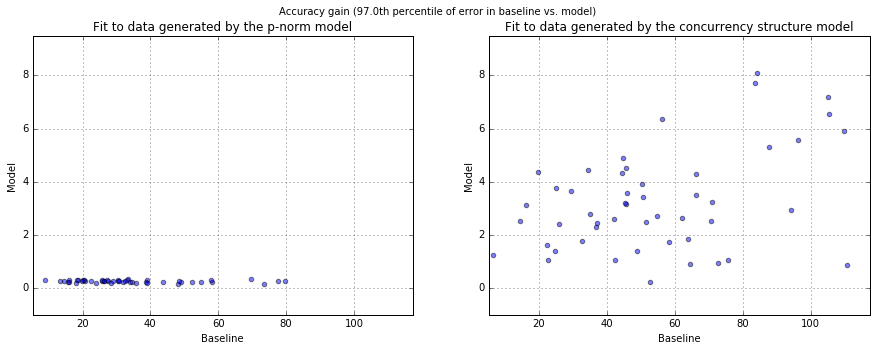

In [41]:
plot_accuracy_gainuracy_gain(pnorm_results, structure_results, percentile=97.)

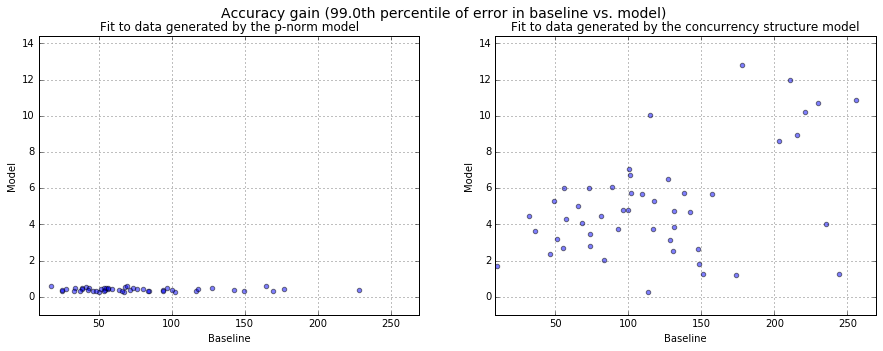

In [47]:
plot_accuracy_gainuracy_gain(pnorm_results, structure_results, percentile=99.)

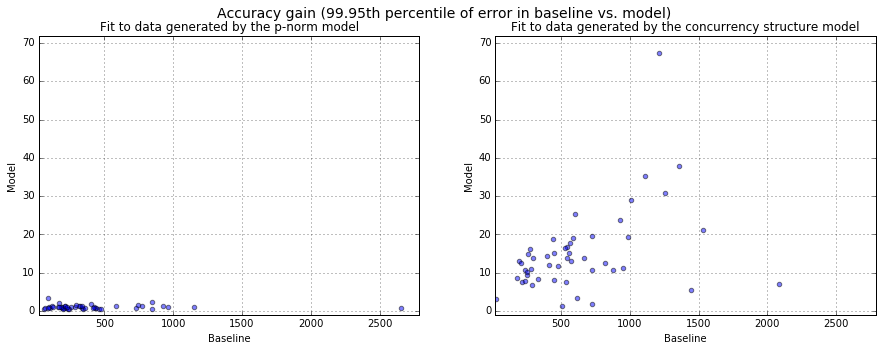

In [48]:
plot_accuracy_gainuracy_gain(pnorm_results, structure_results, percentile=99.95)

The difference in the ways the data is generated does show up in the prediction errors of the p-norm model. Even though the data generated by the concurrency structure model contains no additive noise, the p-norm model could only be fit with a high non-deterministic residual error.

In most cases the predictions of the p-norm model are better (and often considerably better) than the chosen (weak) baseline.

Based on these simulations, taking the 99.95th percentile as the classification threshold would result in the typical thresholds values (for qualifying the transaction as anomalous based on its response time) being below 1 minute (instead of cc. 10 minutes) and a false positive rate of $1:2000$.

# Summary
The p-norm model cannot capture the patterns expressable by the concurrency structure model (which is itself an imperfect model of real call-trees). 

Can we use better (universal) approximators to predict the response time? Some ideas:

* [Radial Basis Function networks](https://en.wikipedia.org/wiki/Radial_basis_function_network) with locally linear models are interesting as the response times of both sequential and parallel concurrency structures can be modeled by piece-wise linear functions. If the radial basis functions can be selected so that they match the linear pieces, we have a good chance to fit accurately.

* [Multi-layer Perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron) with a sigmoid activation function.

* Combine several p-norm models, i.e. use the p-norm as the activation function of neurons (p could be fixed to the distinct value of 1 in half of the neurons and a large integer (mimiquing $\infty$) in the other half).